# CNN practice - Malaria Detection

The data is available from this [Google Drive](https://drive.google.com/u/0/uc?id=1N1gcN8_5dZVlIejoC00QZLSZFhGoSoQb&export=download). For this practice, I placed the unzipped file in the same folder as this notebook.

**ORIGINAL DATA SOURCE:**
The dataset contains 2 folders: *Infected* and *Uninfected* with a total of 27,558 images. I took it from the source assigned by Jose Marcial Portilla (from Pierian Data Inc) for the material of the course Practical AI with Python and Reinforcement Learning on Udemy. The original dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/

In [1]:
import os

In [60]:
# pwd

In [48]:
data_dir = 'cell_images'

In [40]:
os.listdir(data_dir)

['test', 'train']

The following is to import the libraries I'll use.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from matplotlib.image import imread

## The data

In [49]:
train_path = data_dir+'\\train\\'
test_path = data_dir+'\\test\\'

In [50]:
os.listdir(train_path), os.listdir(test_path)

(['parasitized', 'uninfected'], ['parasitized', 'uninfected'])

In [64]:
par_train_num = len(os.listdir(train_path+os.listdir(train_path)[0]))
un_train_num = len(os.listdir(train_path+os.listdir(train_path)[1]))
par_test_num = len(os.listdir(test_path+os.listdir(test_path)[0]))
un_test_num = len(os.listdir(test_path+os.listdir(test_path)[1]))
print(par_train_num, un_train_num, par_test_num, un_test_num)
del par_train_num, un_train_num, par_test_num, un_test_num

12480 12480 1300 1300


In [51]:
# os.listdir(train_path+'parasitized')
os.listdir(train_path+'parasitized')[0]

'C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [52]:
par_cell = train_path+'parasitized\\'+os.listdir(train_path+'parasitized')[0]
par_cell

'cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [54]:
imread(par_cell).shape

(148, 142, 3)

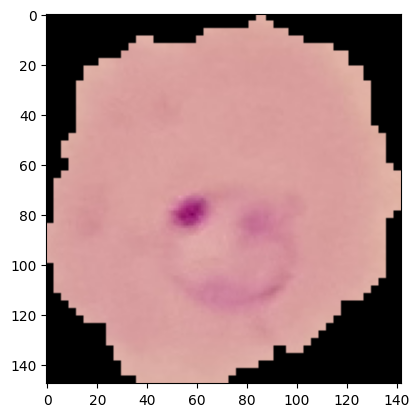

In [55]:
plt.imshow(imread(par_cell))

In [56]:
un_cell = train_path+'uninfected\\'+os.listdir(train_path+'uninfected')[0]

In [57]:
imread(un_cell).shape

(139, 160, 3)

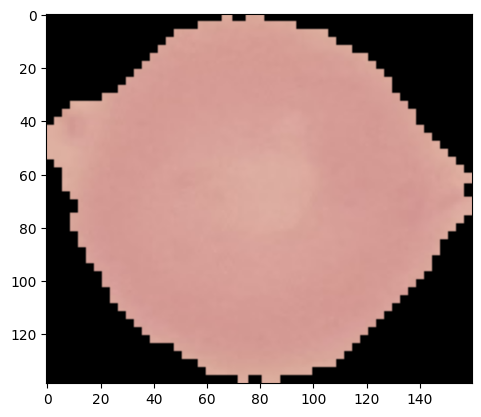

In [58]:
plt.imshow(imread(un_cell))

In [97]:
imread(par_cell).max(), imread(un_cell).max()

(0.9098039, 0.88235295)

It seems the data is already normalized.

As the data have different dimensions, we should change them to have the same size to prepare them for the convolutional model. First, let's look at the images' sizes.

In [66]:
dim1 = []
dim2 = []

for img_name in os.listdir(test_path+'uninfected'):
    img = imread(test_path+'uninfected\\'+img_name)
#     d1,d2,colors = img.shape
    dim1.append(img.shape[0])
    dim2.append(img.shape[1])

In [83]:
df = pd.DataFrame({'dim1':dim1,'dim2':dim2})

In [87]:
# df

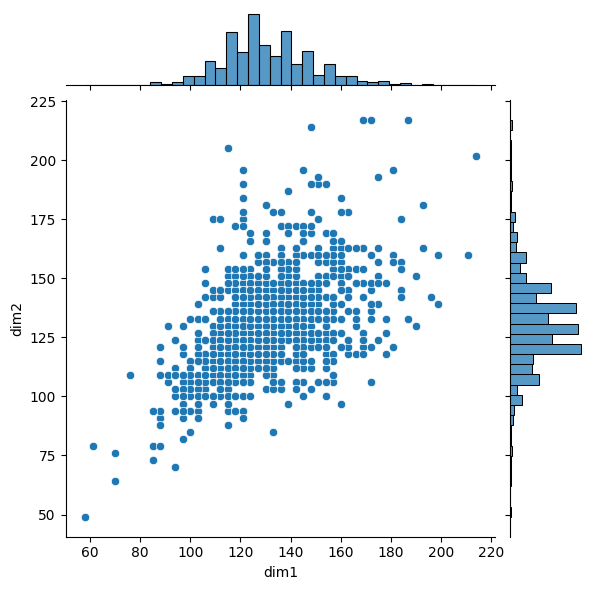

In [86]:
sns.jointplot(df,x='dim1',y='dim2')

In [88]:
np.mean(dim1), np.mean(dim2)

(130.92538461538462, 130.75)

Based on this, I'll choose 130x130 to be the size of all pictures

In [89]:
img_shape = (130,130,3)

## Image Data Generator

As the number of the total images are very low (trainig: 2x12,480 and testing: 2x1300), it would be an idea to generate pseudo-images by manipulating the available images. To do so, let's use *[ImagaeDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)* tool.

In [90]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [92]:
# help(ImageDataGenerator)

In [114]:
img_gen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.10,
                             height_shift_range=0.10,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                            )

Let's see how this ImageDataGenerator affects the images.

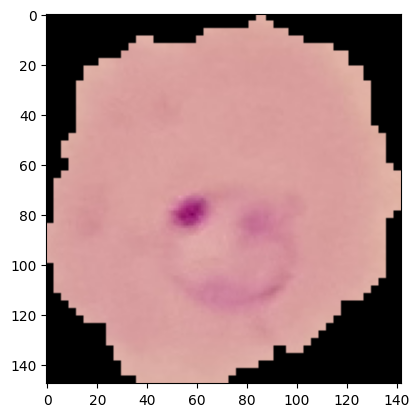

In [110]:
plt.imshow(imread(par_cell))

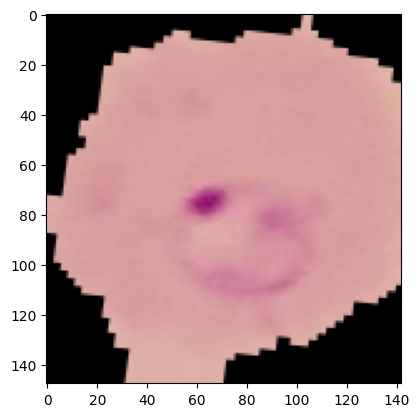

In [118]:
plt.imshow(img_gen.random_transform(imread(par_cell)))

In [120]:
img_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [ ]:
img

## Creating the model

In [123]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Dropout

In [160]:
model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(3,3),
                 input_shape=img_shape, activation='relu',))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(5,5),
                 input_shape=img_shape, activation='relu',))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(7,7),
                 input_shape=img_shape, activation='relu',))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# output layer for binary classification: sigmoid activation
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [161]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 16)        3216      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 24, 24, 16)        12560     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 12, 12, 16)      

### Early Stopping

In [137]:
from tensorflow.keras.callbacks import EarlyStopping

In [153]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Image Generator

In [169]:
img_train_gen = img_gen.flow_from_directory(train_path,
                                            batch_size = 8,
                                            target_size = img_shape[:2],
                                            color_mode = 'rgb',
                                            class_mode = 'binary'
                                           )

Found 24958 images belonging to 2 classes.


In [170]:
img_test_gen = img_gen.flow_from_directory(test_path,
                                           batch_size = 8,
                                           target_size = img_shape[:2],
                                           color_mode = 'rgb',
                                           class_mode = 'binary',
                                           shuffle=False #The test dataset shouldn't be shuffled
                                          )

Found 2600 images belonging to 2 classes.


In [195]:
img_train_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

### Training

In [172]:
# model.fit(img_train_gen, epochs = 20,
#           validation_data=img_test_gen,
#           callbacks=[early_stop]
#          )

In here, I stopped the training, and load the a pre-trained model (see below) provided within the course material. **I don't share this file, as it belongs to the course material.**

### Save & Load the model for later re-use

In [147]:
from tensorflow.keras.models import load_model

In [148]:
# model.save('malaria_detector.h5')

In [173]:
model = load_model('malaria_detector.h5')

In [188]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

## Evaluating Model Performance

In [175]:
model.evaluate(img_test_gen)

325/325 [==============================] - 9s 29ms/step - loss: 34.9396 - accuracy: 0.8727


[34.939632415771484, 0.8726922869682312]

In [189]:
preds = model.predict(img_test_gen)

325/325 [==============================] - 9s 28ms/step


To convert the probabilities to the categories, we need to define a threshold, which should be decided based on the policy. For example, if we don't want to miss any chance of a positive test, we can set the value to ~80, meaning that only if the probability of finding an uninfected cell is higher than 80%, we're going to label it as uninfected.

In [192]:
# predictions = predictions > 0.5
predictions = np.where(preds > 0.8, 1,0)

In [193]:
from sklearn.metrics import classification_report, confusion_matrix

In [194]:
print(classification_report(img_test_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1300
           1       0.98      0.76      0.85      1300

    accuracy                           0.87      2600
   macro avg       0.89      0.87      0.87      2600
weighted avg       0.89      0.87      0.87      2600



In [196]:
confusion_matrix(img_test_gen.classes,predictions)

array([[1277,   23],
       [ 313,  987]], dtype=int64)

## Study a single image

In [197]:
par_cell

'cell_images\\train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [198]:
from tensorflow.keras.preprocessing import image

In [202]:
my_img = image.load_img(par_cell, target_size = img_shape)

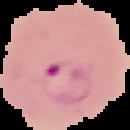

In [203]:
my_img

In [204]:
my_img_arr = image.img_to_array(my_img)

In [208]:
my_img_arr.shape

(130, 130, 3)

In [209]:
my_img_arr = my_img_arr.reshape(1,130,130,3)

In [211]:
model.predict(my_img_arr)

1/1 [==============================] - 0s 58ms/step


array([[0.]], dtype=float32)

In [212]:
img_train_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

The model predicts the cell is of class 0, that is 'parasitized'.